### Safegraph Foot Traffic - Point Pattern Analysis

Authors: Lydia Lo and Anuj Agarwal

The purpose of this notebook is to analyze the distribution of historical foot traffic across Perpetual's partner cities to (1) confirm that the distributions are non-random and (2) naively identify foot traffic "hot spots" (clusters) as potential locations for outdoor foodware collection bins. Hilo, Hawaii, is used as a case study.


#### Imports


In [1]:
%load_ext autoreload
%autoreload 2

# Third-party imports
import pandas as pd
from IPython.core.display import HTML

# Application imports
from utils.constants import DATA_DIR
from utils.point_pattern import (
    calculate_dispersion,
    draw_hexbins,
    draw_scatterplot,
    draw_standard_deviational_ellipse,
    run_hdbscan,
    plot_clusters,
    summarize_clusters,
)
from utils.safegraph import (
    explode_dataset,
    get_top_location_categories,
    plot_top_restaurants,
    preview_dataset,
    split_into_months,
    summarize_column_ranges,
)

#### 1. Data Characteristics

The foot traffic patterns dataset for Hilo contains 41 columns and 47,954 rows. Each row represents a summary of traffic at a geofenced location for a given month (e.g., March 2019). Data originates from cell phone pings from a randomly-sampled panel of cell phone devices. Relevant columns for our analysis include: "safegraph_place_id", "location_name", "latitude", "longitude", "raw_visitor_counts", "date_range_start", "date_range_end", "raw_visit_counts", "raw_visitor_counts", and "related_same_day_brand".


In [2]:
# Load data file
hilo_df = pd.read_parquet(f"{DATA_DIR}/foot-traffic/hilo_full_patterns.parquet")
preview_dataset(hilo_df)

'47,954 record(s) and 41 column(s)'

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs'],
      dtype='object')

,sub_category,safegraph_place_id,location_name,latitude,longitude,raw_visitor_counts,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,related_same_day_brand
2353,Other Individual and Family Services,sg:a6abadf575c64c7aa2957973c322c258,YMCA,19.705079,-155.080101,NaN,None,None,NaN,NaN,None
3153,Full-Service Restaurants,sg:e170329441704027b328f7603705729f,Happy Valley Seafood Restaurant,19.710198,-155.076062,45.0,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,72.0,45.0,{}
3422,Retail Bakeries,sg:f6130790a4c7440592d15fe1a58888a6,Two Ladies Kitchen,19.721123,-155.084421,NaN,None,None,NaN,NaN,None
4179,Nature Parks and Other Similar Institutions,sg:2dc8ca526096494b8694c5ba704704f1,Wailoa River State Recreation Area,19.716826,-155.066791,9.0,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,59.0,9.0,"{""Panda Express"":50,""Target"":48}"
9436,Courts,sg:9ce49fae5cba4828990d087fb1eaaf75,Hawaii Probation Office,19.718644,-155.079238,58.0,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,206.0,58.0,"{""7-Eleven"":19,""76"":17,""Starbucks"":11,""Walmart..."


The data ranges from January 2018 to March 2021. The median number of visits per location per month is 61, but the minimum is one and the maximum is 14,828 (the Waiakea Center, a shopping mall).


In [3]:
summarize_column_ranges(hilo_df)

,latitude,longitude,raw_visitor_counts,raw_visit_counts,raw_visitor_counts
count,45290.000000,45290.000000,34111.000000,34111.000000,34111.000000
mean,19.711862,-155.076886,89.365718,181.342118,89.365718
std,0.015871,0.019507,219.888706,562.998385,219.888706
min,19.549075,-155.328179,1.000000,1.000000,1.000000
25%,19.703146,-155.086631,10.000000,16.000000,10.000000
50%,19.715916,-155.076533,31.000000,61.000000,31.000000
75%,19.722954,-155.064939,87.000000,171.000000,87.000000
max,19.756069,-155.009353,4497.000000,14828.000000,4497.000000


min    2018-01-01T00:00:00-10:00
max    2021-02-01T00:00:00-10:00
Name: date_range_start, dtype: object

min    2018-02-01T00:00:00-10:00
max    2021-03-01T00:00:00-10:00
Name: date_range_end, dtype: object

In [4]:
get_top_location_categories(hilo_df)

,sub_category,raw_visit_counts
0,Malls,"602,596"
1,Full-Service Restaurants,"529,243"
2,Nature Parks and Other Similar Institutions,"384,621"
3,Limited-Service Restaurants,"291,692"
4,Gasoline Stations with Convenience Stores,"266,486"
5,Pharmacies and Drug Stores,"264,382"
6,Department Stores,"212,927"
7,Other Airport Operations,"210,743"
8,All Other General Merchandise Stores,"199,401"
9,Snack and Nonalcoholic Beverage Bars,"186,357"


#### 2. Point Pattern Analysis


##### Data Transformation


In [5]:
hilo_visits_gdf = explode_dataset(hilo_df)
hilo_visits_gdf.head()

,date_range_start,date_range_end,latitude,longitude,geometry
0,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,19.710198,-155.076062,POINT (-155.07606 19.71020)
1,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,19.710198,-155.076062,POINT (-155.07606 19.71020)
2,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,19.710198,-155.076062,POINT (-155.07606 19.71020)
3,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,19.710198,-155.076062,POINT (-155.07606 19.71020)
4,2020-04-01T00:00:00-10:00,2020-05-01T00:00:00-10:00,19.710198,-155.076062,POINT (-155.07606 19.71020)


##### Visit Scatterplot

The scatter plot part shows the correlation between the longitude and latitude. The histogram on the sides shows the distribution of each variable independently. We see dots are concentrated in the upper quadrant of the covered area in a non-random pattern and that there are localized clusters within the broader pattern at the top and at the right hand side.


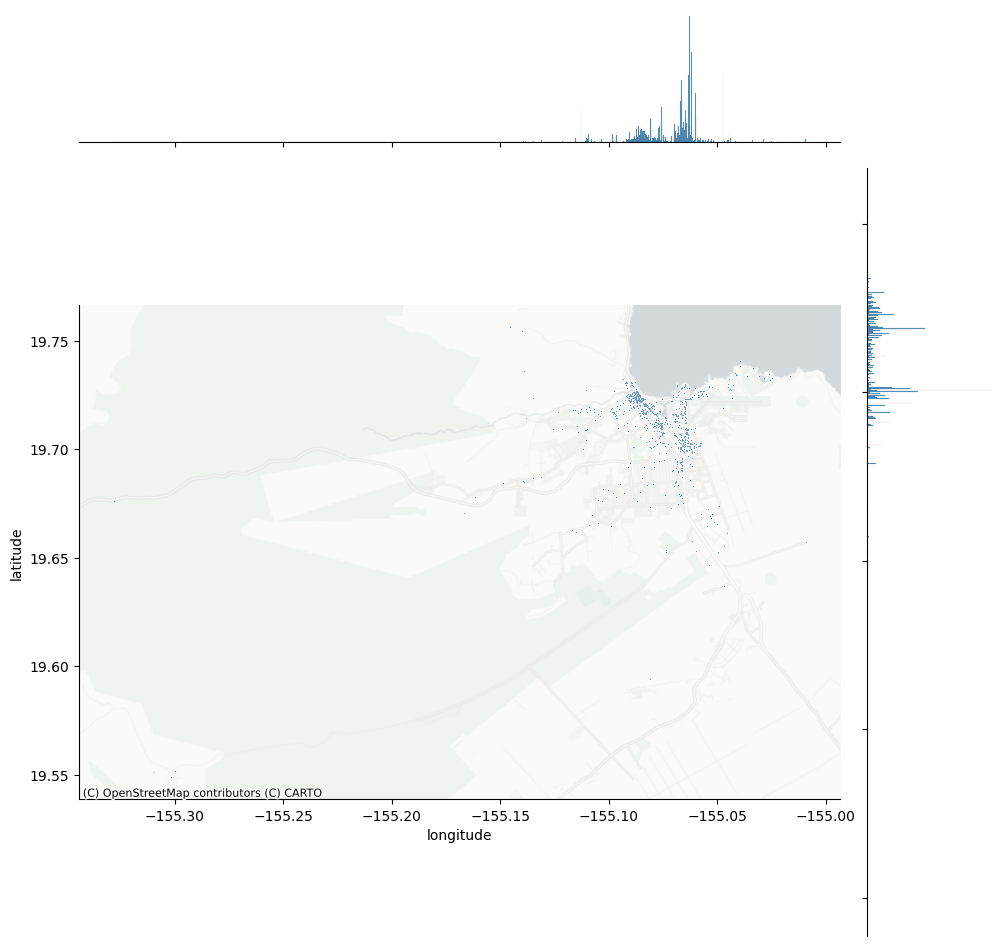

In [6]:
draw_scatterplot(hilo_visits_gdf, lat_col="latitude", lon_col="longitude")

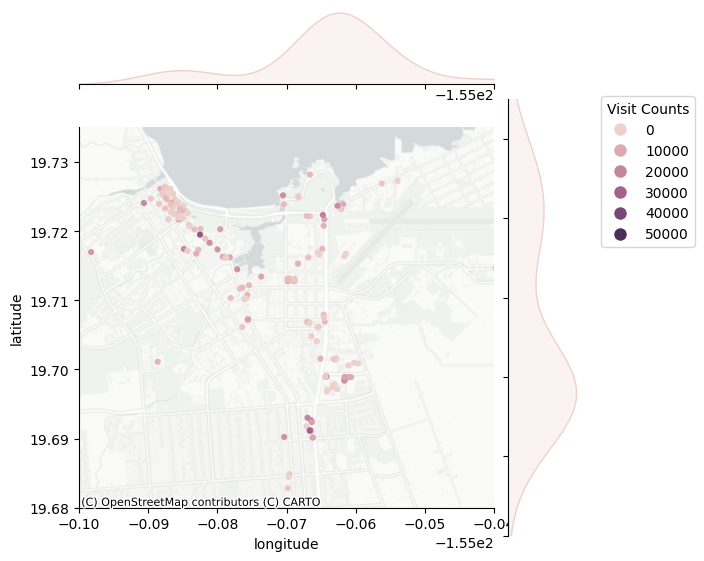

None

In [7]:
plot_top_restaurants(hilo_df)

##### Visit Hexbins


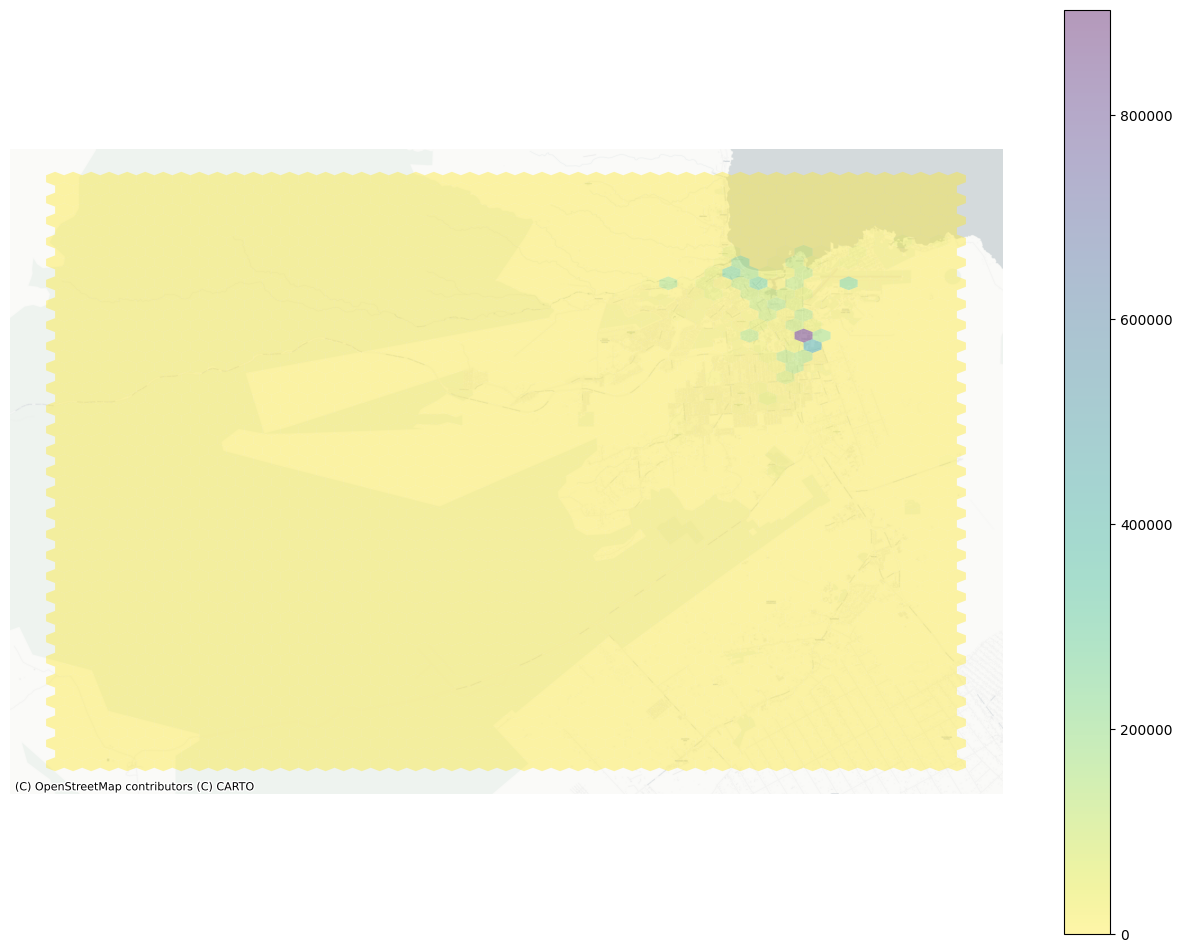

In [8]:
draw_hexbins(hilo_visits_gdf, lat_col="latitude", lon_col="longitude", zoom=15)

##### Dispersion


'Approximately 2,247.5168862426644 Meters'

'19.708979399782876 degrees latitude, -155.07188522124736 degrees longitude'

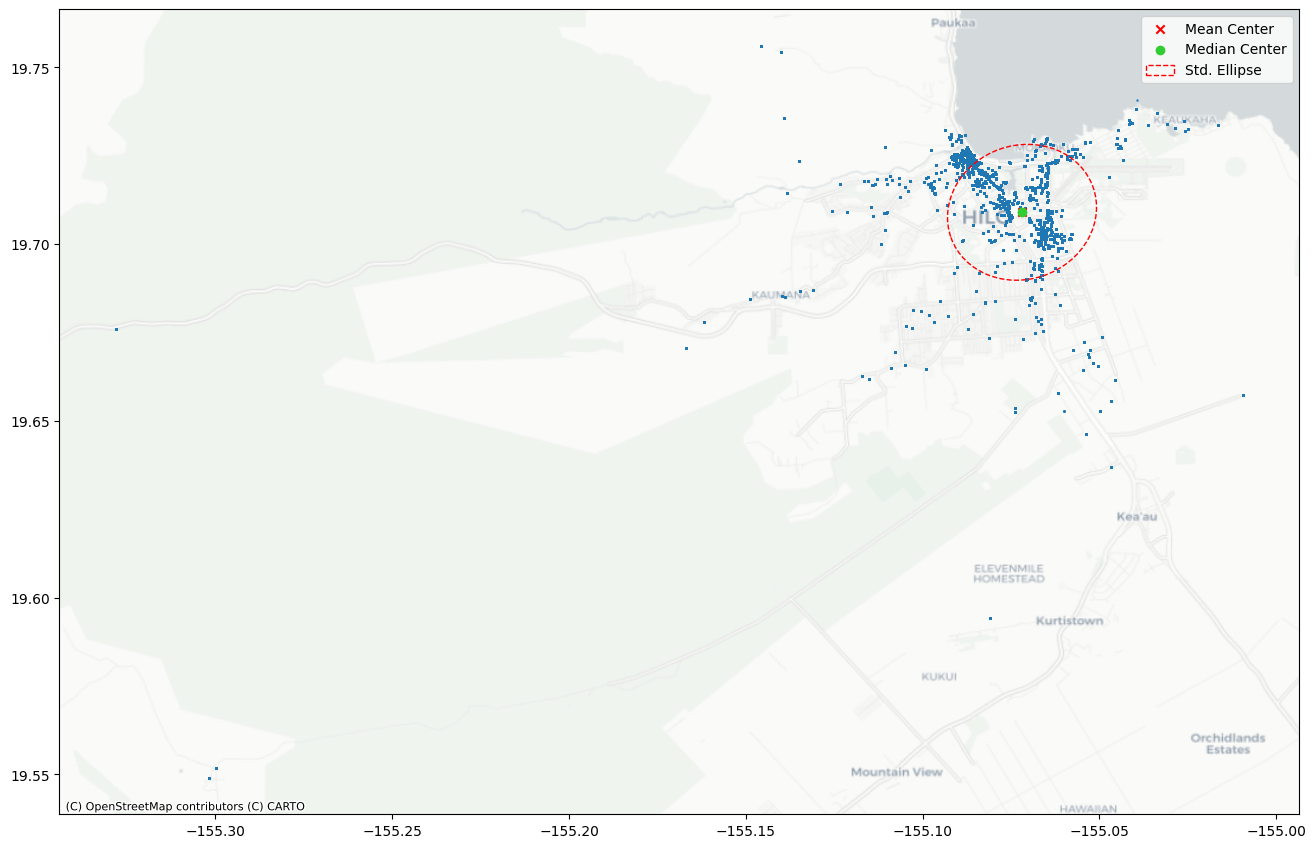

In [9]:
# Calculate mean center and standard distance away from center
mean_center, std_distance = calculate_dispersion(hilo_visits_gdf.geometry)

# Summarize results
display(HTML("<b>Standard Distance:</b>"))
display(f"Approximately {std_distance:,} Meters")
display(HTML("<b>Mean Center:</b>"))
display(f"{mean_center.y} degrees latitude, {mean_center.x} degrees longitude")

# Draw deviational ellipse
draw_standard_deviational_ellipse(hilo_visits_gdf.geometry, mean_center)

This means that on average, foot traffic occurs around 2258 meters away from the mean center.


##### Clustering


In [10]:
# Split into months
df_lst = split_into_months(hilo_visits_gdf, "Hilo, HI")

In [11]:
# Cluster month as example
clusters_df, utm_crs = run_hdbscan(
    df_lst[0], min_cluster_size=50, min_samples=20
)
clusters_df

,date_range_start,date_range_end,latitude,longitude,geometry,month,cluster
3030864,2019-01-01T00:00:00-10:00,2019-02-01T00:00:00-10:00,19.715628,-155.085761,POINT (281391.820 2181355.957),1,331
3030865,2019-01-01T00:00:00-10:00,2019-02-01T00:00:00-10:00,19.715628,-155.085761,POINT (281391.820 2181355.957),1,331
3030866,2019-01-01T00:00:00-10:00,2019-02-01T00:00:00-10:00,19.715628,-155.085761,POINT (281391.820 2181355.957),1,331
3030867,2019-01-01T00:00:00-10:00,2019-02-01T00:00:00-10:00,19.715628,-155.085761,POINT (281391.820 2181355.957),1,331
3030868,2019-01-01T00:00:00-10:00,2019-02-01T00:00:00-10:00,19.715628,-155.085761,POINT (281391.820 2181355.957),1,331
...,...,...,...,...,...,...,...
5031970,2018-01-01T00:00:00-10:00,2018-02-01T00:00:00-10:00,19.706744,-155.063927,POINT (283669.056 2180344.411),1,491
5031971,2018-01-01T00:00:00-10:00,2018-02-01T00:00:00-10:00,19.706744,-155.063927,POINT (283669.056 2180344.411),1,491
5031972,2018-01-01T00:00:00-10:00,2018-02-01T00:00:00-10:00,19.706744,-155.063927,POINT (283669.056 2180344.411),1,491
5031973,2018-01-01T00:00:00-10:00,2018-02-01T00:00:00-10:00,19.684595,-155.148869,POINT (274731.647 2178002.606),1,-1


In [12]:
# Summarize clusters
cluster_summary_df = summarize_clusters(clusters_df)
cluster_summary_df

,cluster_label,num_points,geometry
0,0,56,POINT (258695.667 2163512.322)
1,1,159,POINT (258495.032 2163207.040)
2,2,1126,POINT (289326.361 2174797.911)
3,3,218,POINT (275887.335 2181282.256)
4,4,102,POINT (278141.154 2175495.335)
...,...,...,...
709,709,171,POINT (281184.102 2182443.890)
710,710,51,POINT (281402.008 2182295.932)
711,711,88,POINT (281405.703 2182289.464)
712,712,230,POINT (281176.876 2182457.377)


In [13]:
# Plot clusters
plot_clusters(cluster_summary_df, utm_crs)

#### Conclusions

- Foot traffic distributions in Hilo can be confirmed as non-random
- Hot spots in the city can be determined and visualized through solely foot traffic data 
- Foot traffic hot spots in Hilo are centered and distributed around the Waiakea Center and the Hilo International Airport
